# OCR and Annotation on PPTX file

In this cookbook, we will explore the basics of Annotations and how to extract structured outputs 
from a PPTX file using the Mistral OCR API.

This notebook runs OCR on `data/sample.pptx` and prints the results inline.

> Make sure you have a valid **MISTRAL_API_KEY** in your environment or edit the cell below.

## 1) Install dependencies

In [ ]:
# Install the Mistral client library
%pip install mistralai pydantic


## 2) Configure paths & client

In [ ]:
import json
import base64
from enum import Enum
from pydantic import BaseModel, Field
from mistralai import Mistral
from mistralai.extra import response_format_from_pydantic_model

# --- File paths ---
doc_path = "../../data/sample.pptx"

# --- Client ---
api_key = "API_KEY" # Replace with your API key
client = Mistral(api_key=api_key)

print("Using:", doc_path)

Using: ../../data/sample.pptx


## 3) Define schemas for annotations

In [ ]:
class ImageType(str, Enum):
    GRAPH = "graph"
    TEXT = "text"
    TABLE = "table"
    IMAGE = "image"

class Image(BaseModel):
    image_type: ImageType = Field(..., description="The type of the image. Must be one of 'graph', 'text', 'table' or 'image'.")
    description: str = Field(..., description="A description of the image.")

class Document(BaseModel):
    summary: str = Field(..., description="A summary of the document.")
    models: str = Field(..., description="A list of models provided by Mistral AI​.")

## 4) Helper: read file(s) as base64

In [16]:
def encode_file_b64(path: str):
    try:
        with open(path, "rb") as f:
            return base64.b64encode(f.read()).decode("utf-8")
    except FileNotFoundError:
        print(f"Error: The file {path} was not found.")
        return None
    except Exception as e:
        print("Error:", e)
        return None

base64_doc = encode_file_b64(doc_path)
assert base64_doc is not None, "Input PPTX not found – check path."

## 5) Run OCR (Full Text)

=== OCR Output ===
{
  "pages": [
    {
      "index": 0,
      "markdown": "# Frontier AI. \u000bIn your hands.\nConfigurable AI for all builders\n\n# July 2025\n\nConfidential ©2025 Mistral AI\\. All rights reserved\\.",
      "images": [],
      "dimensions": null
    },
    {
      "index": 1,
      "markdown": "# The Mistral AI model landscape\n\n__Our __  __moderation service__  __ to detect __  __harmful__  __ text content__\n\n__Our __  __most __  __efficient / powerful__  __edge__  __ models__\n\n![img-0.jpeg](img-0.jpeg)\n\n![img-1.jpeg](img-1.jpeg)\n\n__Our __  __frontier\\-class reasoning __  __model__\n\n__Our flagship model\\, for__  __your __  __most sophisticated needs__\n\n![img-2.jpeg](img-2.jpeg)\n\n![img-3.jpeg](img-3.jpeg)\n\n__Mistral Moderation__\n\n__Mistral Medium 3__\n\n__Magistral Medium __\n\n__The world’s __  __best OCR model __  __to\\-date__\n\n![img-4.jpeg](img-4.jpeg)\n\n__Our __  __embedding model__  __ to make your data accessible__\n\n__Our __  __low
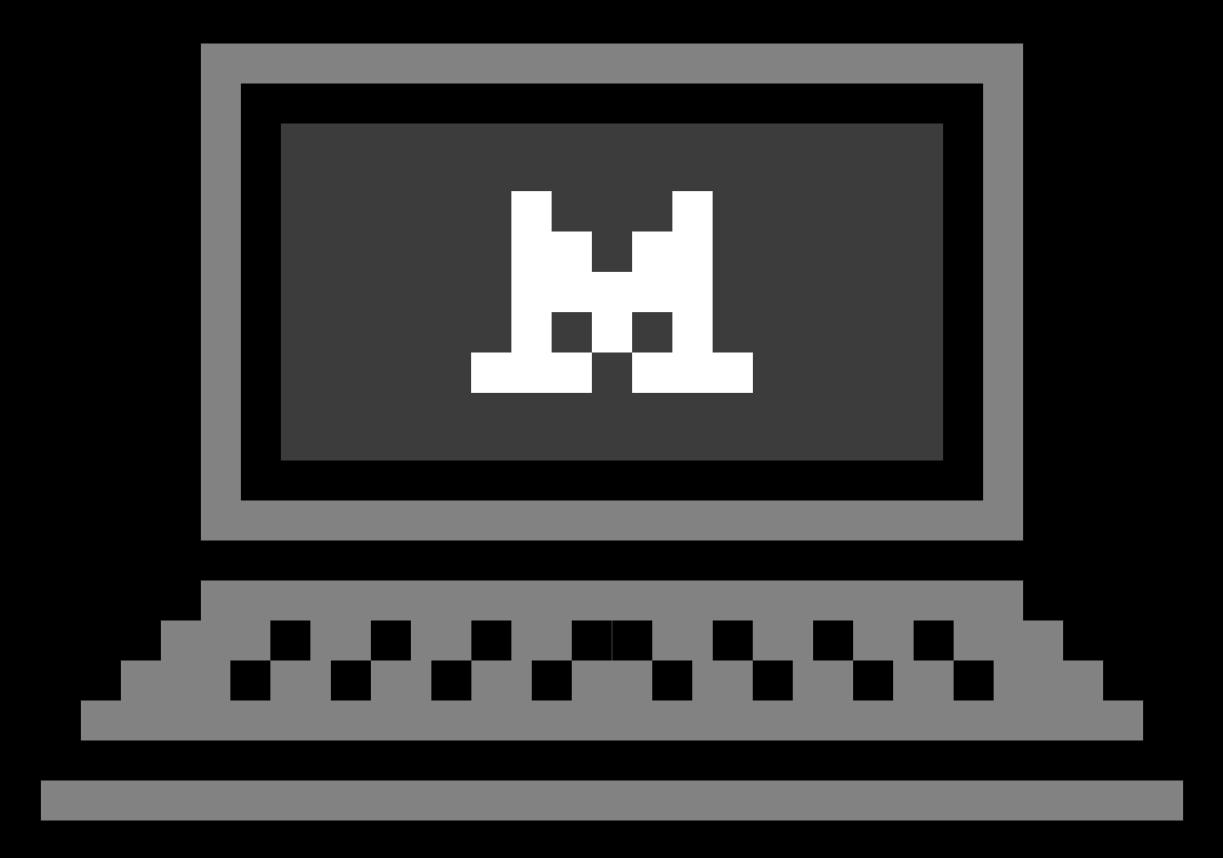
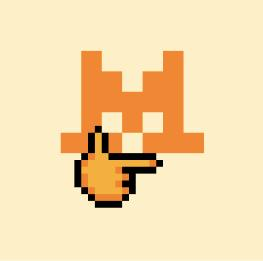
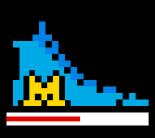
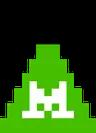
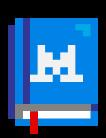
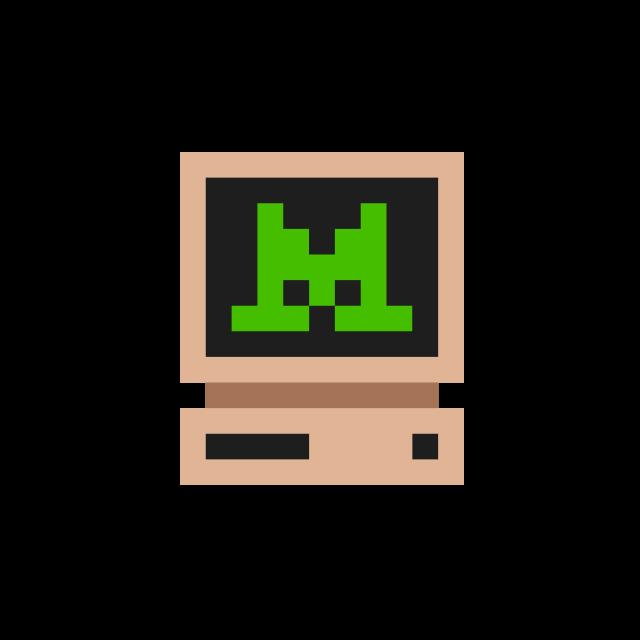
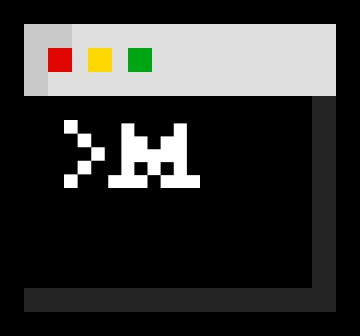
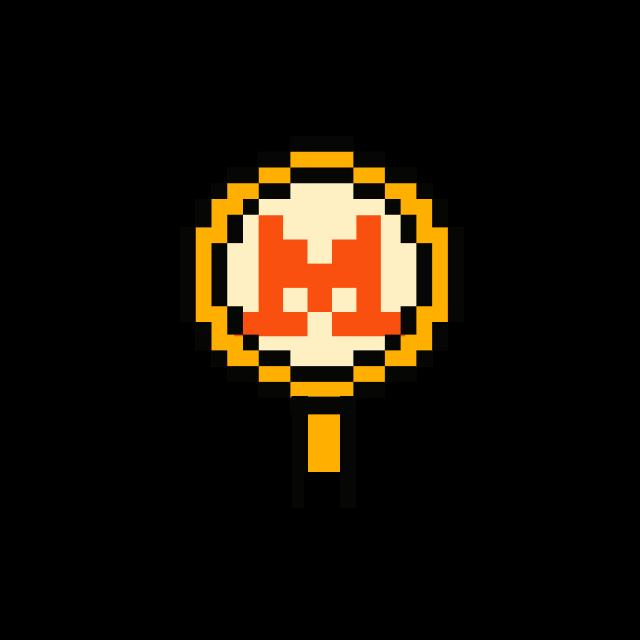
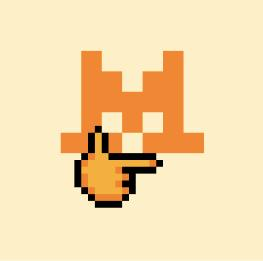
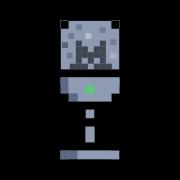
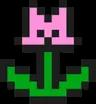
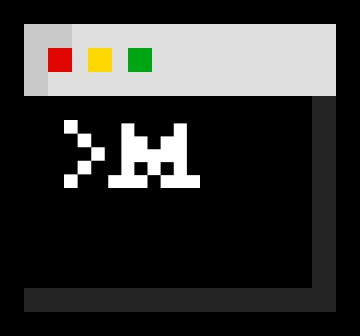
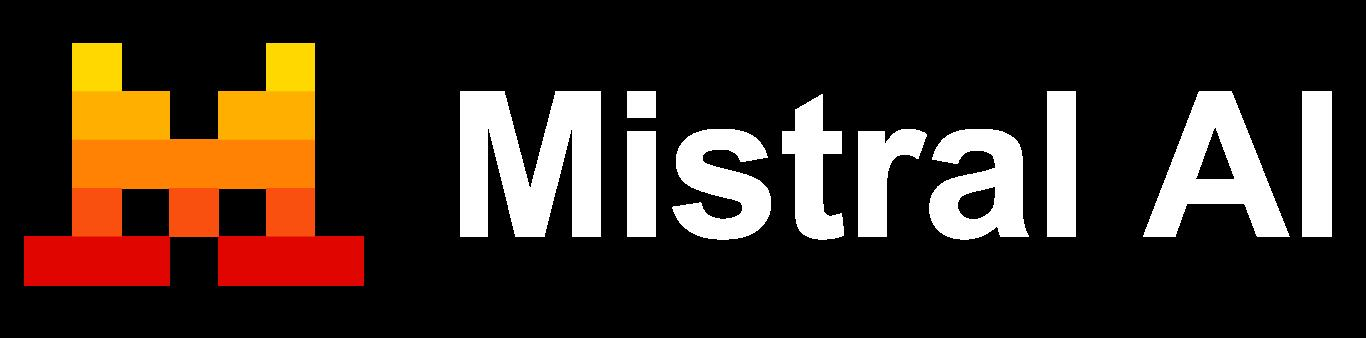
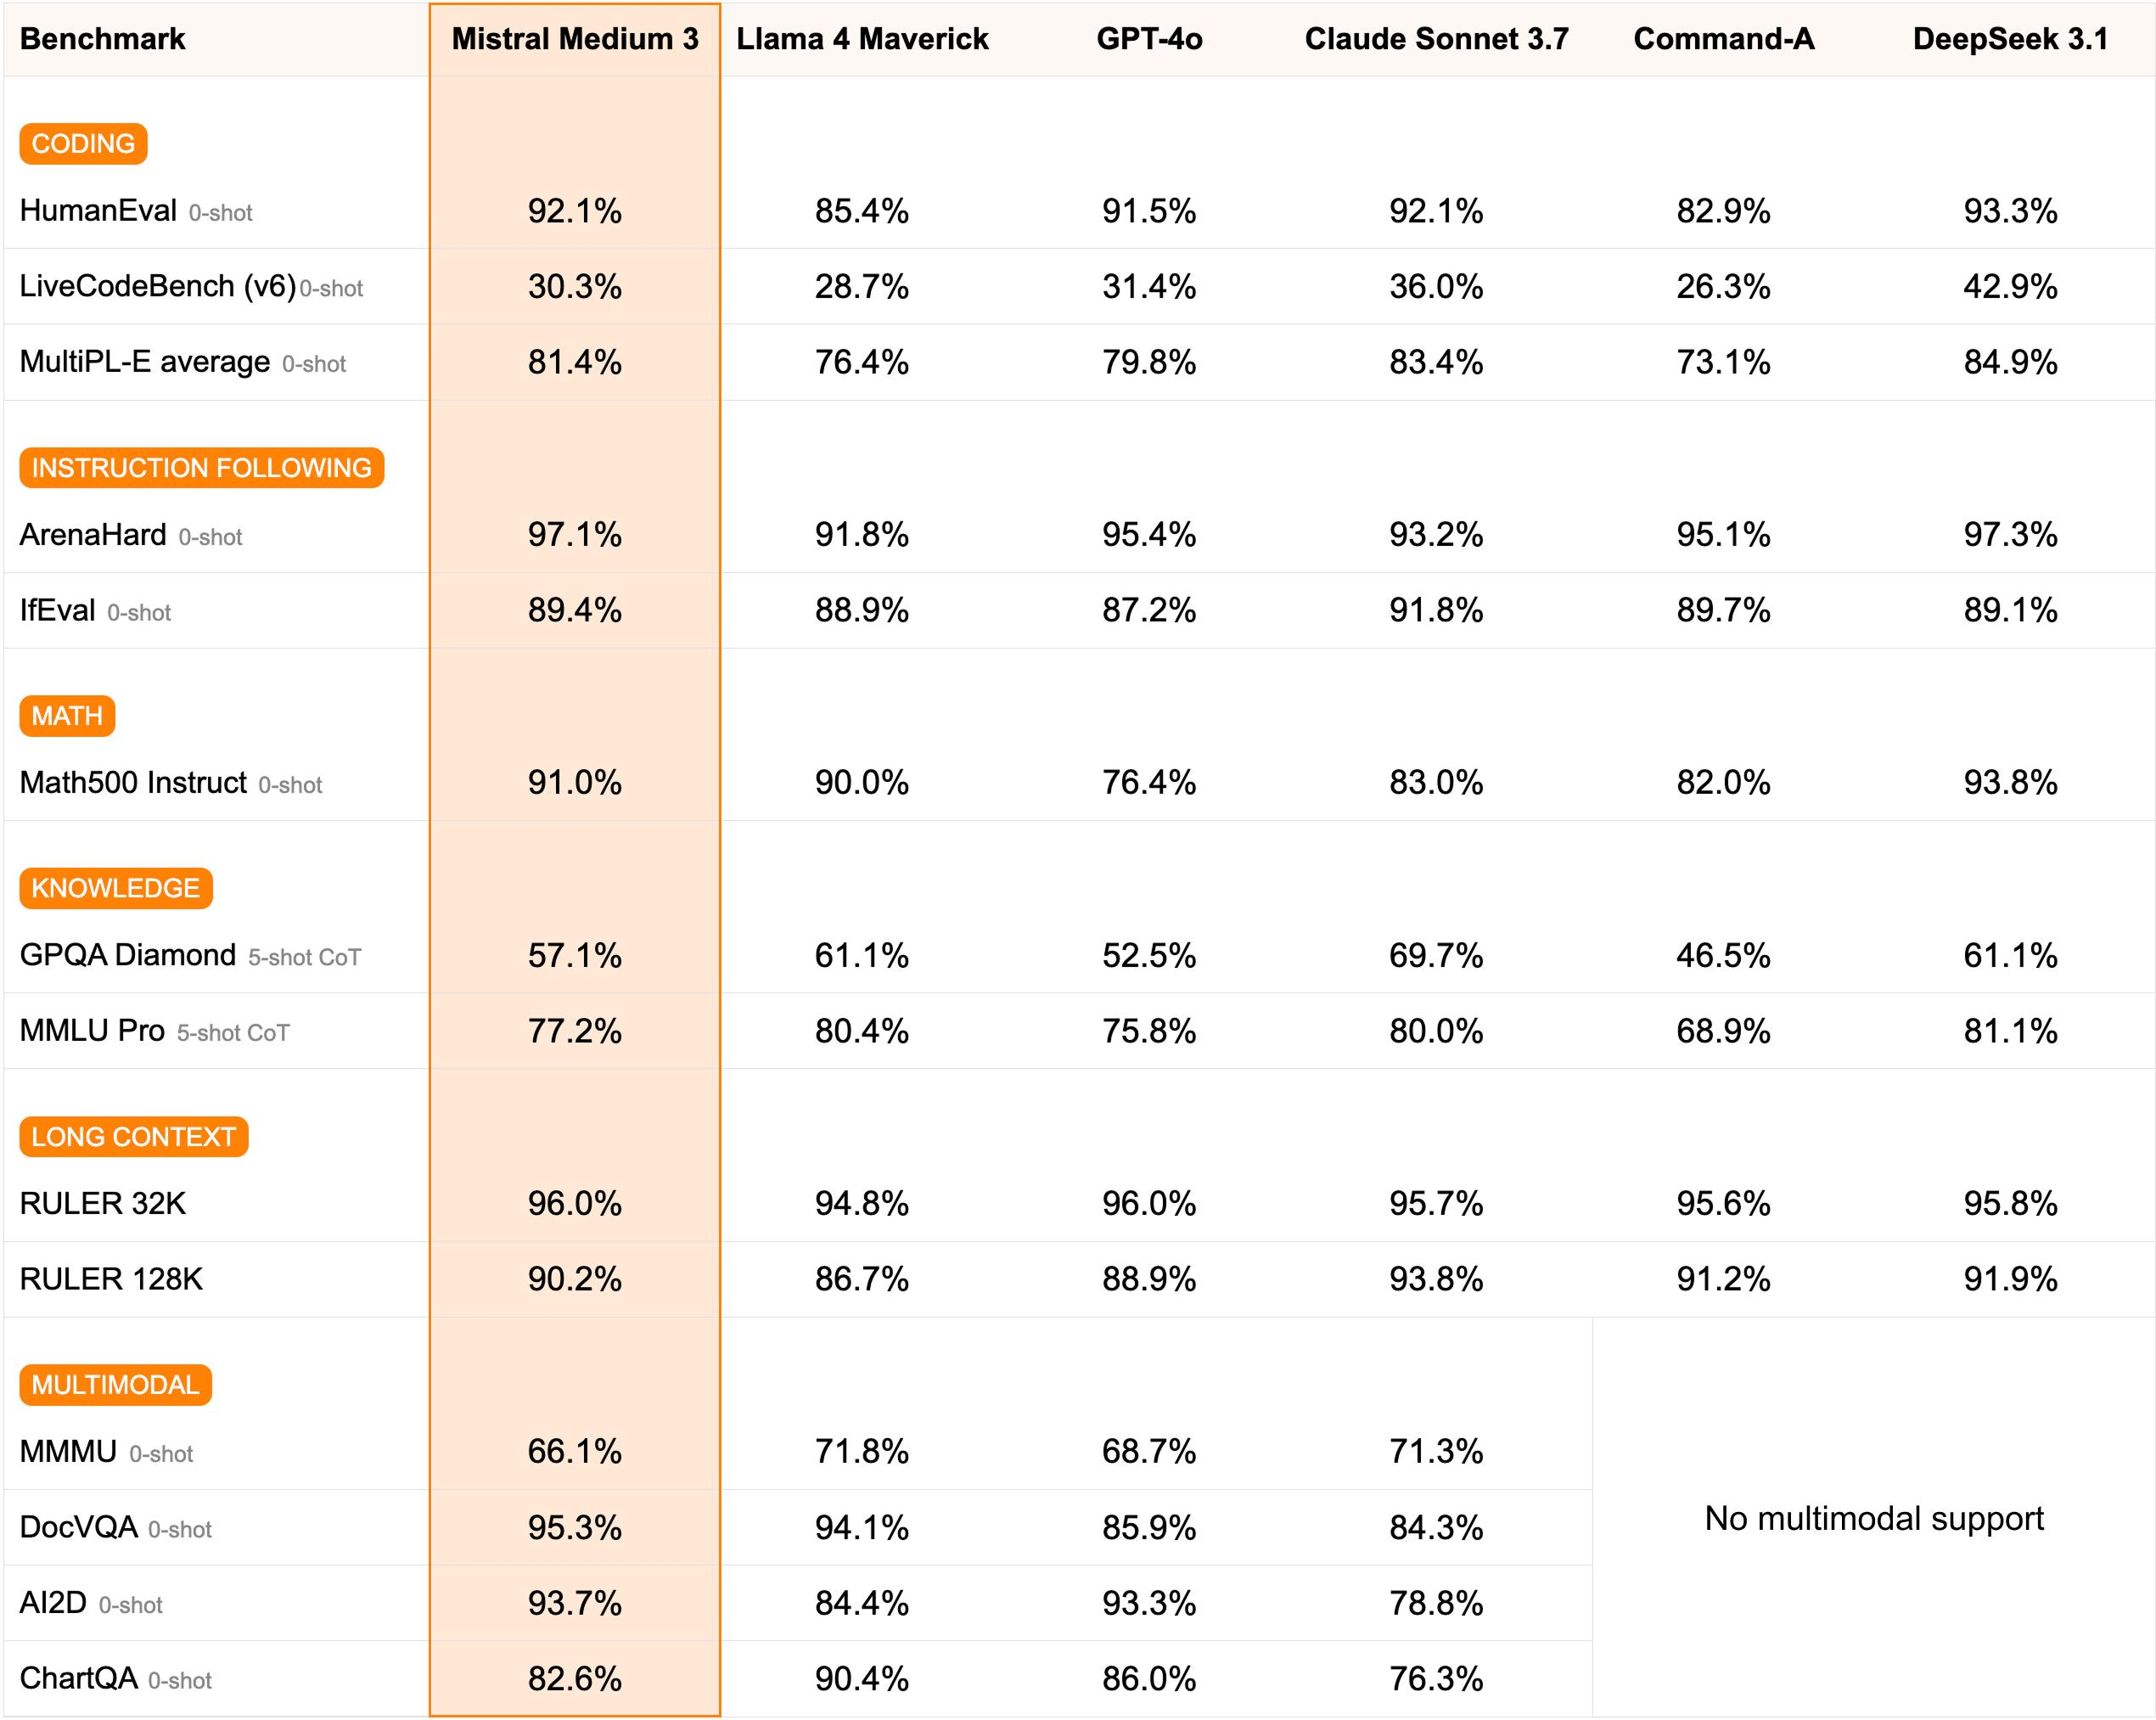
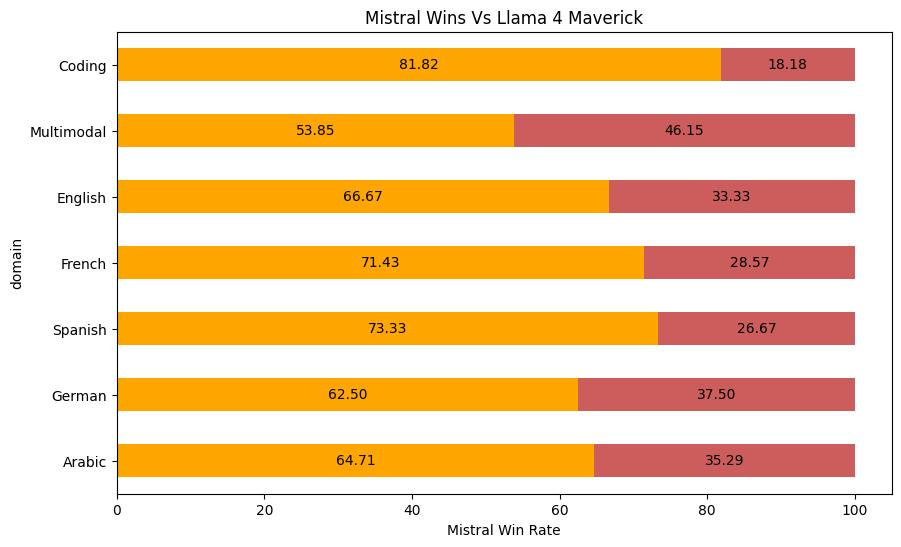
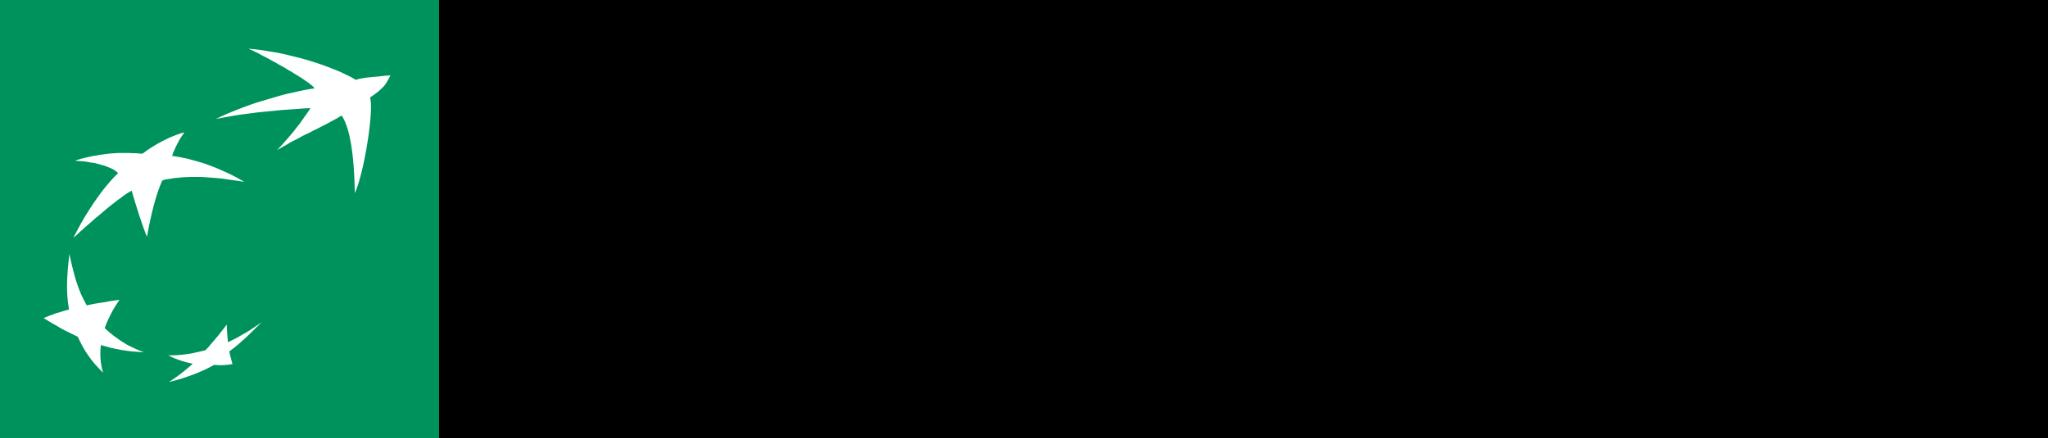
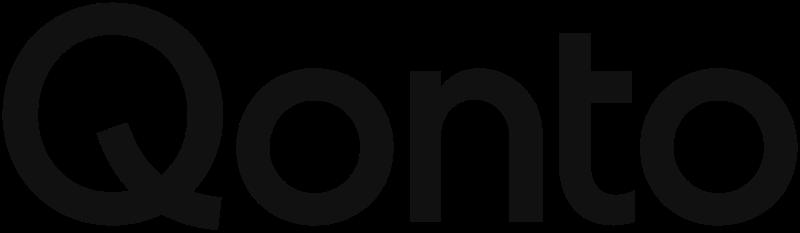
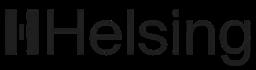
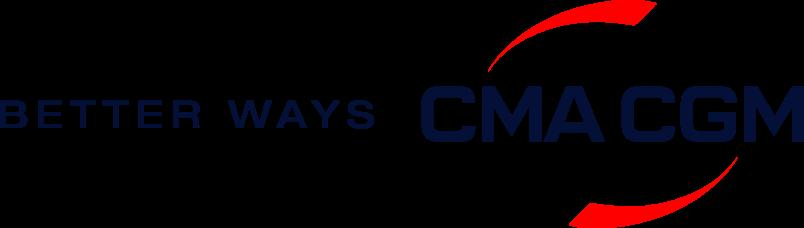
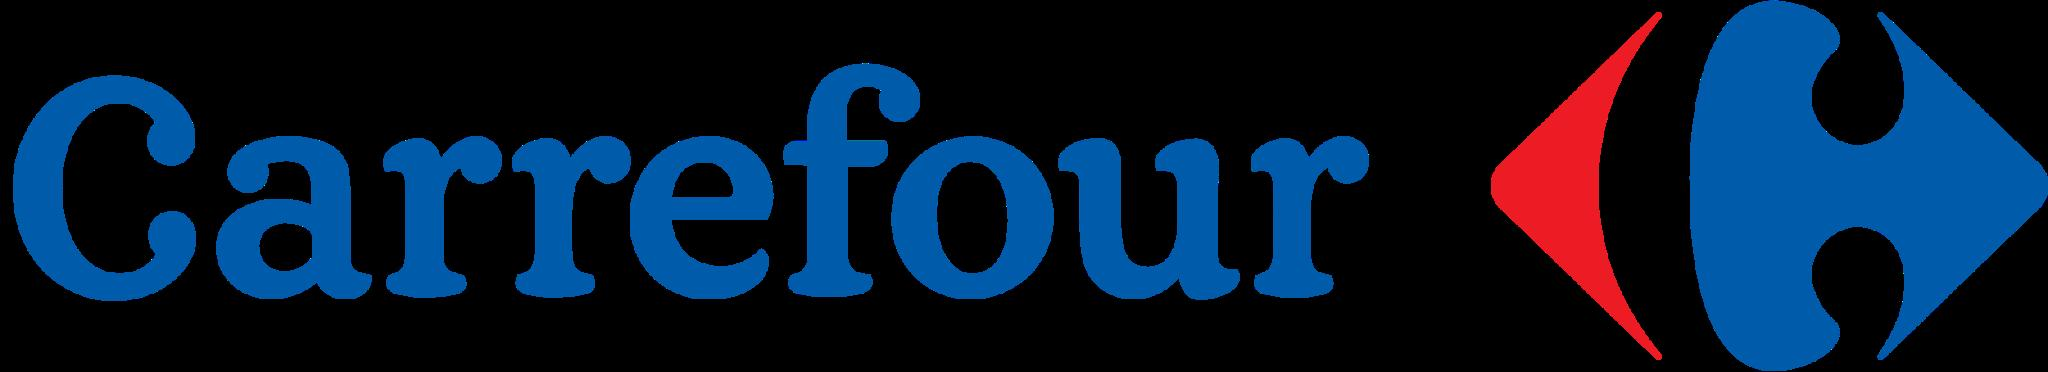
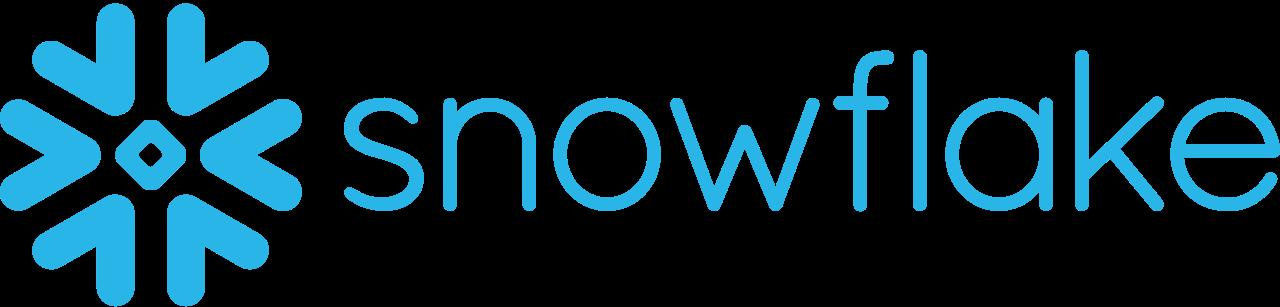
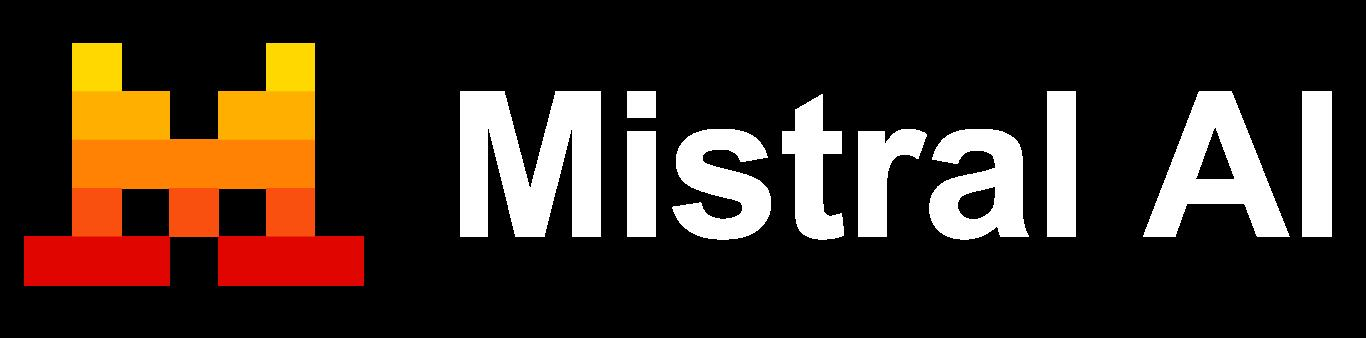

In [18]:
# URL for PPTX so OCR can read it directly
# Use application/vnd.openxmlformats-officedocument.wordprocessingml.document for DOCX
data_url = f"data:application/vnd.openxmlformats-officedocument.presentationml.presentation;base64,{base64_doc}"

# -- OCR (full) --
ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={"type": "document_url", "document_url": data_url},
    include_image_base64=True,
)

ocr_dict = json.loads(ocr_response.model_dump_json())

# Print nicely
print("=== OCR Output ===")
print(json.dumps(ocr_dict, indent=2, ensure_ascii=False))


## 6) Run OCR with Annotations

=== OCR Annotations Output ===
{
  "pages": [
    {
      "index": 0,
      "markdown": "# Frontier AI. \u000bIn your hands.\nConfigurable AI for all builders\n\n# July 2025\n\nConfidential ©2025 Mistral AI\\. All rights reserved\\.",
      "images": [],
      "dimensions": null
    },
    {
      "index": 1,
      "markdown": "# The Mistral AI model landscape\n\n__Our __  __moderation service__  __ to detect __  __harmful__  __ text content__\n\n__Our __  __most __  __efficient / powerful__  __edge__  __ models__\n\n![img-0.jpeg](img-0.jpeg)\n\n![img-1.jpeg](img-1.jpeg)\n\n__Our __  __frontier\\-class reasoning __  __model__\n\n__Our flagship model\\, for__  __your __  __most sophisticated needs__\n\n![img-2.jpeg](img-2.jpeg)\n\n![img-3.jpeg](img-3.jpeg)\n\n__Mistral Moderation__\n\n__Mistral Medium 3__\n\n__Magistral Medium __\n\n__The world’s __  __best OCR model __  __to\\-date__\n\n![img-4.jpeg](img-4.jpeg)\n\n__Our __  __embedding model__  __ to make your data accessible__\n\n__O
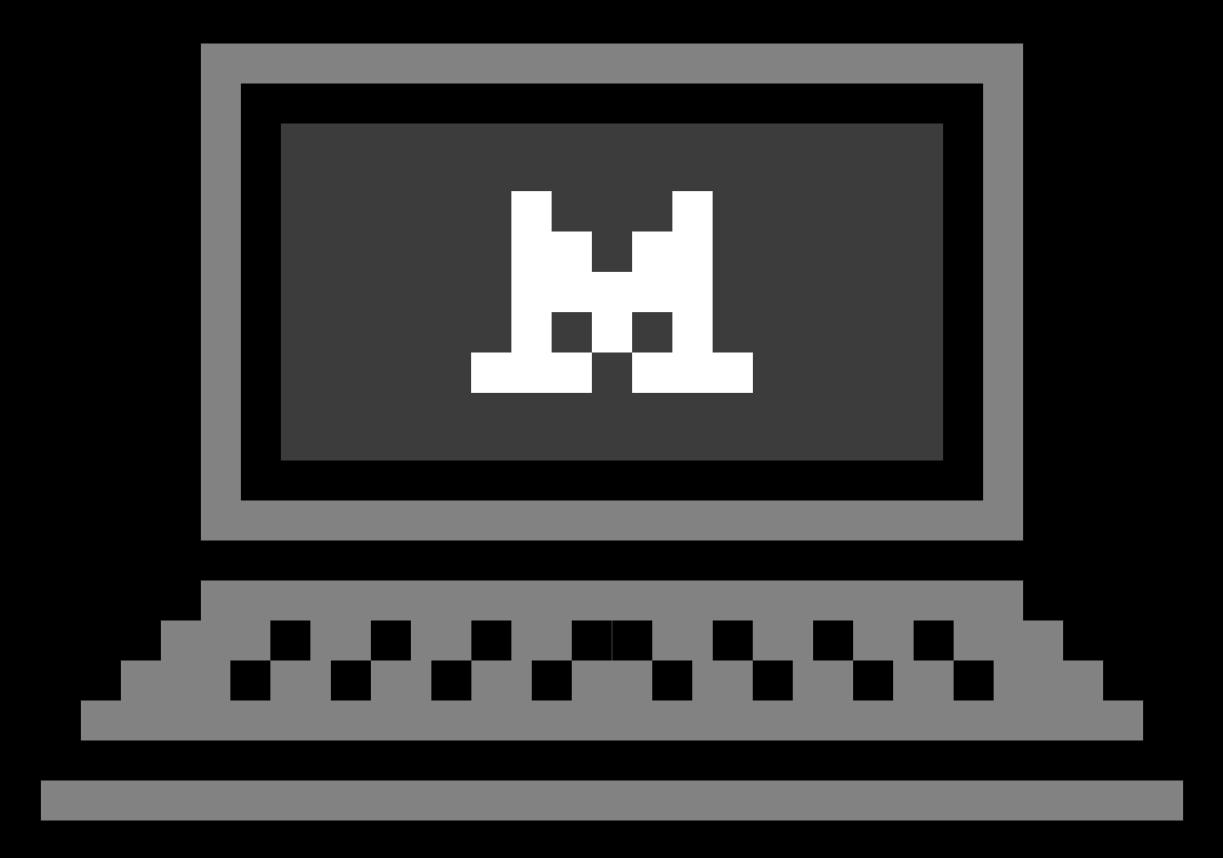
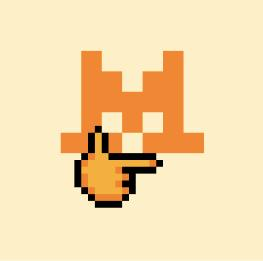
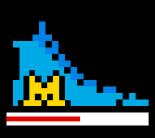
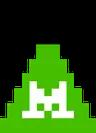
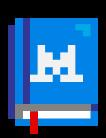
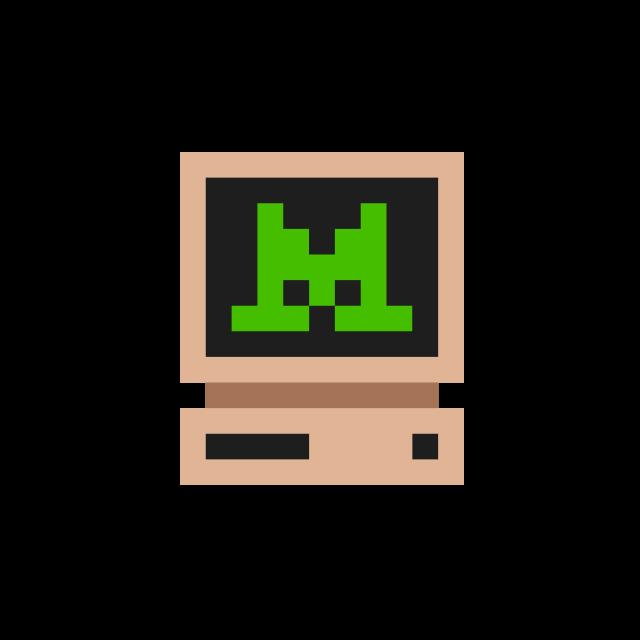
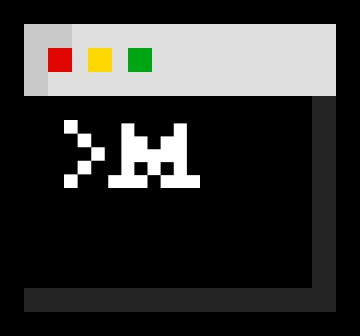
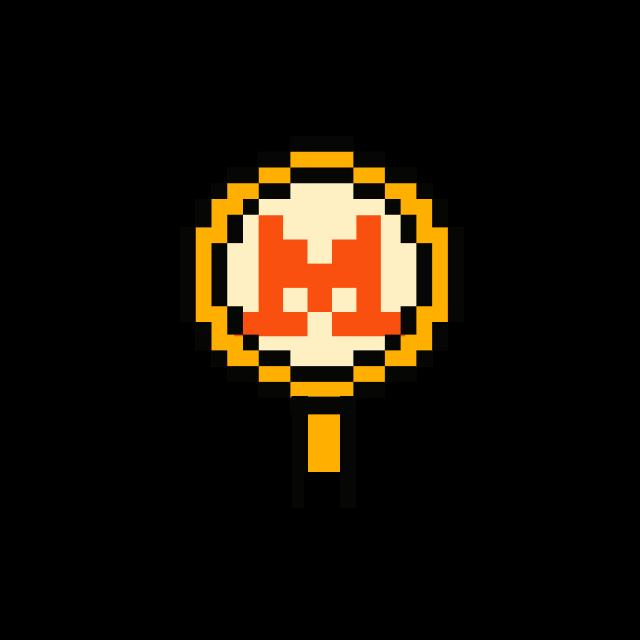
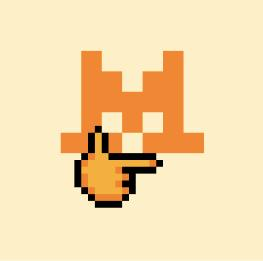
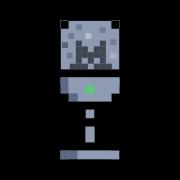
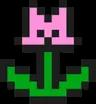
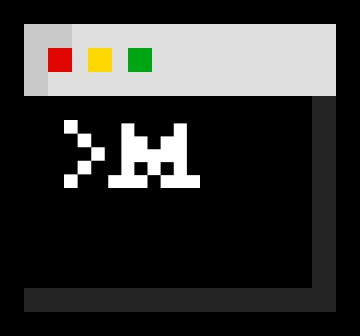
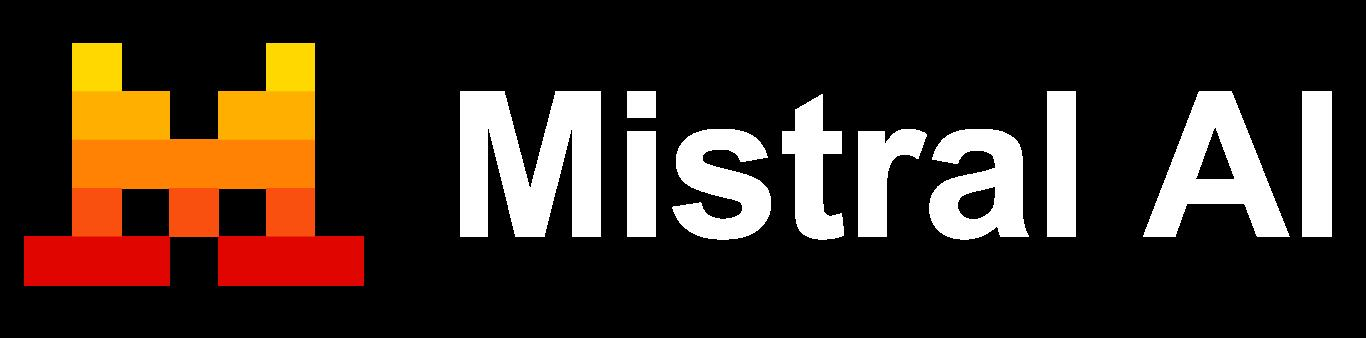
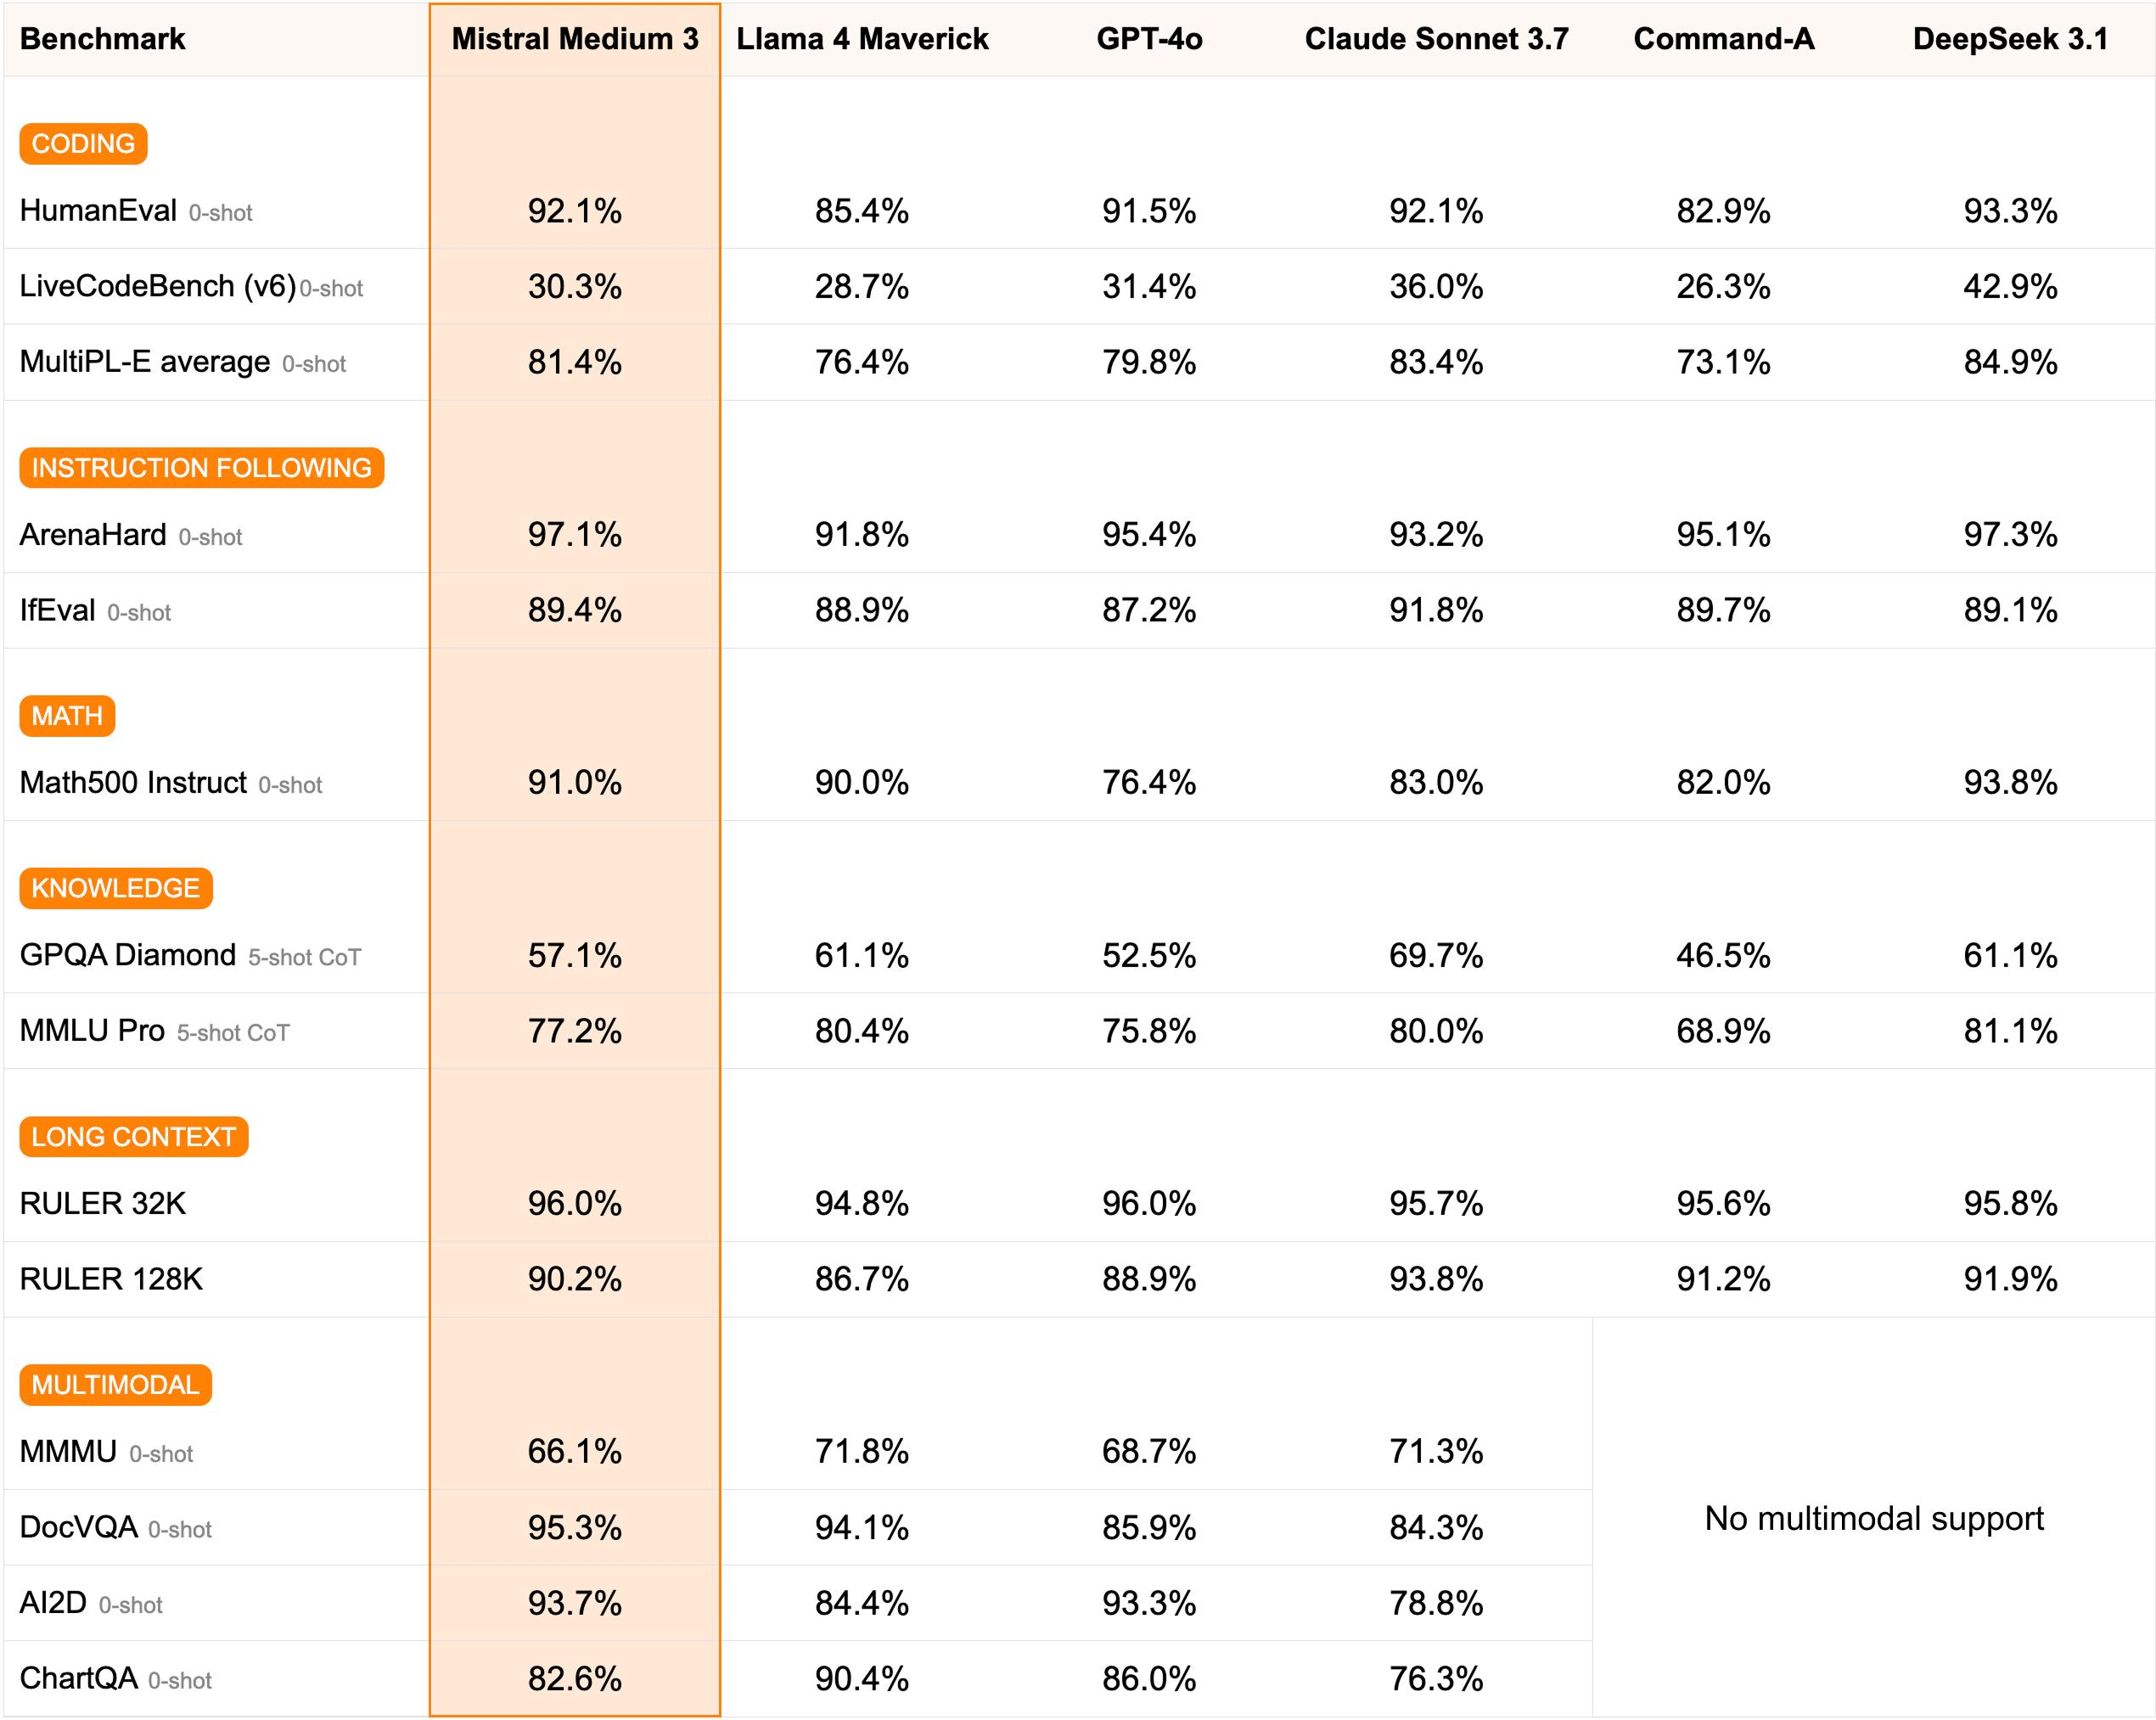
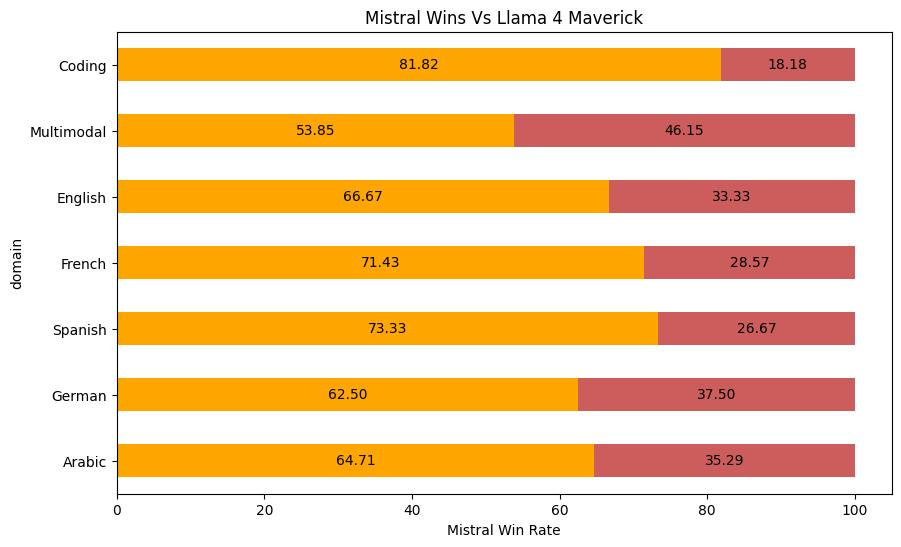
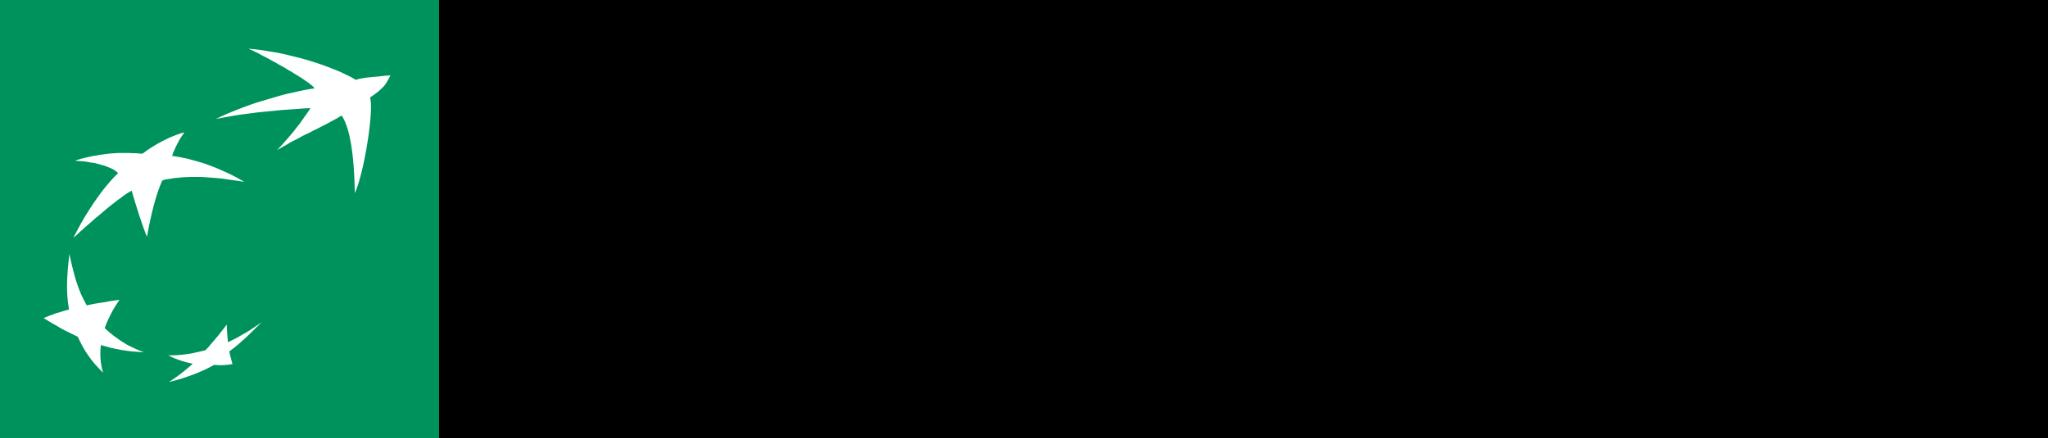
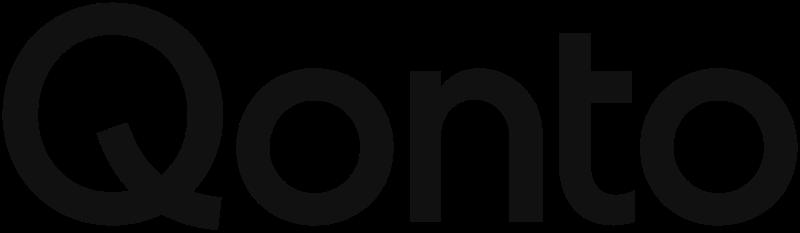
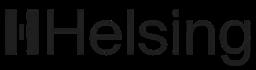
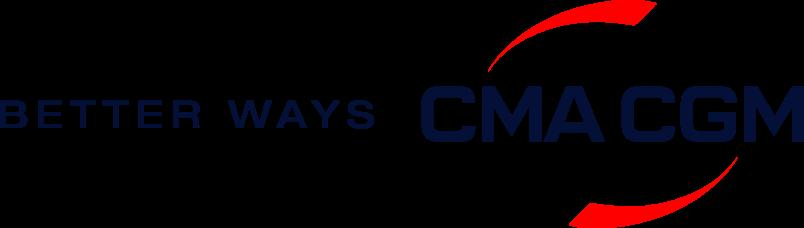
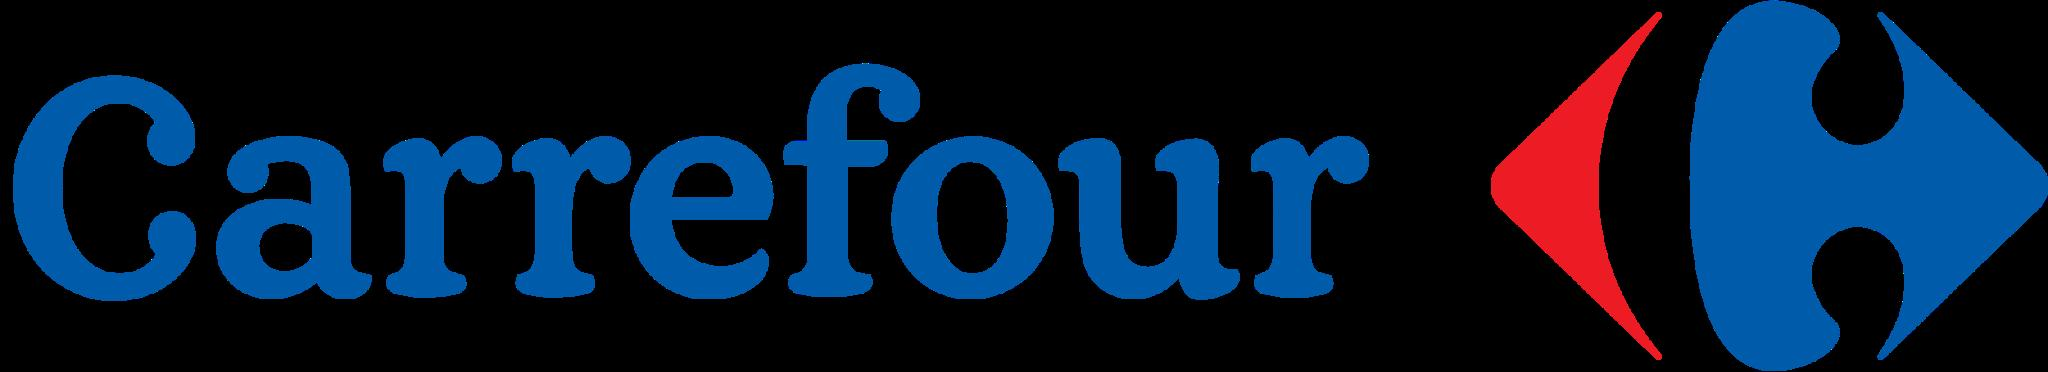
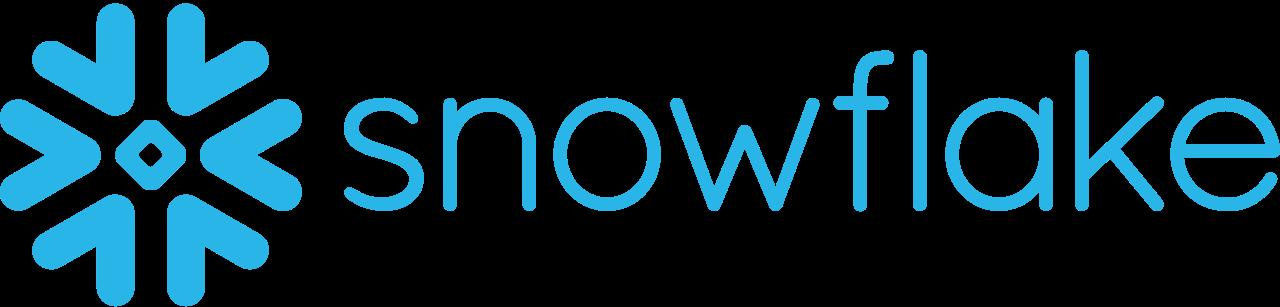
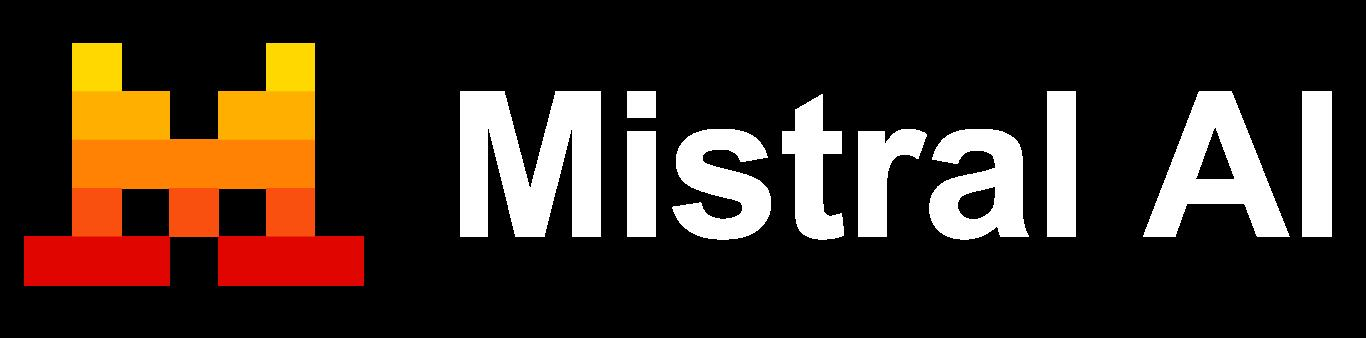

In [ ]:
# -- OCR (annotations) --
annotations_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={"type": "document_url", "document_url": data_url},
    bbox_annotation_format=response_format_from_pydantic_model(Image),
    document_annotation_format=response_format_from_pydantic_model(Document),
    image_limit=30
)

annotations_dict = json.loads(annotations_response.model_dump_json())

# Print nicely
print("=== OCR Annotations Output ===")
print(json.dumps(annotations_dict, indent=2, ensure_ascii=False))
